# Assignment 7: Semantic Segmentation
Heute werden wir einfache Netzwerkarchitekturen für "Semantic Segmentation" testen. Ziel ist es dieses Paper in den Grundzügen zu implementieren: https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf

## Daten

Es gibt einige gute Datensätze, die ihr (bei gegebener Hardware) herunterladen und benutzen könnt. Für diejenigen, die auf CPUs rechnen gilt immer der Tip: Bilder downsamplen!

Sucht Euch einen Satensatz aus: 

KITTI: http://www.cvlibs.net/download.php?file=data_semantics.zip (~300 MB, 200 Bilder)

DUS: http://www.6d-vision.com/scene-labeling (~3 GB, 500 Bilder)

MIT. http://sceneparsing.csail.mit.edu/ (~1 GB, links siehe auf Seite)

## Exc. 7.1 Fully convolutional network, no downsampling
Implementiere die in der Vorlesung besprochene Netzwerkarchitektur von aufeinanderfolgenden CONV-Schichten (stride=1, mit zero-padding), um eine Ausgabeschicht zu bekommen, die die Eingabegröße aufweist. Tip: die letzte CONV-Schicht sollte eine Tiefe haben, die zur Zahl der Klassen korrespondiert. Benutze den L2-Loss zum Labelbild (Achtung: ihr müsst dafür entweder das Labelbild oder den Ausgabetensor umformulieren).

Trainiere das Netzwerk auf den von Dir gewählten Datensatz und zeige den Verlauf des Losses, und einige zufällig gewählte Beispielbilder mit ihren vorhergesagten Segmentierungen an. (**RESULT**)

# Disclaimer: We use the first dataset

In [1]:
import tensorflow as tf
import numpy as np
from keras.backend.tensorflow_backend import set_session, get_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

import os
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

c:\users\eduard gette\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
batch_size = 32
image_input_size = (112, 112)
data_path = r'C:\Users\Eduard Gette\Documents\Computer Vision\data_semantics'

In [3]:
train_data_path = os.path.join(data_path, 'training')
val_data_path = os.path.join(data_path, 'testing')

generator = ImageDataGenerator(horizontal_flip=False, rescale=1/255.0)
val_generator = ImageDataGenerator(horizontal_flip=False, rescale=1/255.0)

train_gen = generator.flow_from_directory(
    train_data_path, 
    target_size=image_input_size,
    batch_size=batch_size)

val_gen = val_generator.flow_from_directory(
    val_data_path, 
    target_size=image_input_size,
    batch_size=batch_size)

Found 800 images belonging to 4 classes.
Found 200 images belonging to 1 classes.


### Gewinne einen Eindruck davon, wie die Annotation Maps aussehen. Aus diesen werden wir pro Bild einen Tensor erstellen, der einen Eintrag 1 in der Ebene hat, zu welcher Klasse er gehört

In [2]:
from skimage import io
import numpy as np

In [3]:
img1 = io.imread(r'C:\Users\Eduard Gette\Documents\Computer Vision\data_semantics\training\semantic\000000_10.png')

In [7]:
# http://www.cvlibs.net/datasets/kitti/eval_semseg.php?benchmark=semantics2015
# check whether label images have the desired format with numbers ranging from 0 - 30
np.min(img1), np.max(img1)

(4, 28)

In [8]:
img1

array([[21, 21, 21, ..., 11, 11, 11],
       [21, 21, 21, ..., 11, 11, 11],
       [21, 21, 21, ..., 11, 11, 11],
       ...,
       [ 7,  7,  7, ..., 26, 26, 26],
       [ 7,  7,  7, ..., 26, 26, 26],
       [ 7,  7,  7, ..., 26, 26, 26]], dtype=uint8)

c:\users\eduard gette\appdata\local\programs\python\python36\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
c:\users\eduard gette\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


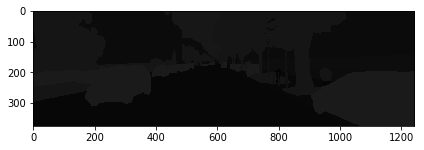

In [9]:
io.imshow(img1)

### Reformat labels to tensors with shape: (number of classes, width, height)

In [4]:
# directory of labels
path = r"C:\Users\Eduard Gette\Documents\Computer Vision\data_semantics\training\semantic"
labels = sorted(os.listdir(path))
nrOfClasses = 30
# can't fit everything in memory so we only work on a small subset of the data
# also the pictures do not have the same size later on & would therefore need to be resized
nrOfExamples = 100

In [5]:
# um bilder kleiner zu machen
from skimage.transform import resize

In [31]:
# empty tensor for our reformated labels
labels_tensor = np.zeros(shape=(nrOfExamples, nrOfClasses, img1.shape[0], img1.shape[1]))

index = 0
for label in labels[:nrOfExamples]:
    
    # load image
    img = io.imread(os.path.join(path,label))
    
    # tensor for one individual label
    label_tensor = np.zeros(shape=(30, img.shape[0], img.shape[1]))

    # in each slice corresponding to one class set the positions to 1 that
    # are labeled with the corresponding class scalar in the original label
    for i in range(30):
        class_mask = (img==i).astype(int)
        label_tensor[i,:,:] = class_mask
        
    labels_tensor[index,:,:,:] = label_tensor
    index += 1

In [7]:
# don't want to wait for recalculation everytime so we save the tensor. Warning: Huge file!
# np.save(open('labels_tensor.npy', 'wb'), labels_tensor)
labels_tensor = np.load('labels_tensor.npy')

In [33]:
# check entries for the 21st class in the 0th example
labels_tensor[0][21,:,:]

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
labels_tensor.shape

(100, 30, 375, 1242)

In [9]:
# reshape into required format
tol = labels_tensor.reshape(nrOfExamples,375,1242,nrOfClasses)

In [10]:
tol.shape

(100, 375, 1242, 30)

# Training

In [13]:
path_to_train = r"C:\Users\Eduard Gette\Documents\Computer Vision\data_semantics\training\image_2"
imgs = np.zeros(shape=(nrOfExamples, img1.shape[0], img1.shape[1], 3))
for i in range(len(labels[:nrOfExamples])):
    label = labels[i]
    img = io.imread(os.path.join(path_to_train,label))
    imgs[i,:,:,:] = img

In [14]:
# this dataset has only labels for the train data so we need to split our subset further into train
# and test dataset: 80 - 20 split
train_percentage = 0.8
train_part = int(nrOfExamples * train_percentage)

X_train = imgs[:train_part,:,:,:]
X_test = imgs[train_part:,:,:,:]

y_train = tol[:train_part,:,:,:]
y_test = tol[train_part:,:,:,:]

In [41]:
# build the model of conv layers in correct size
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(img1.shape[0], img1.shape[1], 3), strides=1, padding="same"))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3), strides=1, padding="same"))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3), strides=1, padding="same"))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3), strides=1, padding="same"))
model.add(Activation('relu'))

model.add(Conv2D(nrOfClasses, (3, 3), strides=1, padding="same"))
model.add(Activation('sigmoid'))

# compile
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

In [15]:
batch_size = nrOfExamples//10
nrOfEpochs = 20

In [50]:
model.fit(X_train, y_train, batch_size=batch_size, verbose=1, epochs=nrOfEpochs)

Epoch 1/20
80/80 [==============================] - 31s 382ms/step - loss: 0.1989 - acc: 0.0127
Epoch 2/20
80/80 [==============================] - 27s 337ms/step - loss: 0.0353 - acc: 0.0016
Epoch 3/20
80/80 [==============================] - 29s 362ms/step - loss: 0.0333 - acc: 0.2603
Epoch 4/20
80/80 [==============================] - 28s 353ms/step - loss: 0.0333 - acc: 0.4920
Epoch 5/20
80/80 [==============================] - 28s 351ms/step - loss: 0.0333 - acc: 0.5724
Epoch 6/20
80/80 [==============================] - 28s 349ms/step - loss: 0.0333 - acc: 0.6071
Epoch 7/20
80/80 [==============================] - 28s 351ms/step - loss: 0.0333 - acc: 0.6239
Epoch 8/20
80/80 [==============================] - 28s 350ms/step - loss: 0.0333 - acc: 0.6324
Epoch 9/20
80/80 [==============================] - 28s 350ms/step - loss: 0.0333 - acc: 0.6362
Epoch 10/20
80/80 [==============================] - 28s 348ms/step - loss: 0.0333 - acc: 0.6383
Epoch 11/20
80/80 [====================

64% acc on training data after 20 epochs - let's see what we get on the test set

In [52]:
evaluation = model.evaluate(x=X_test, y=y_test, batch_size=batch_size, verbose=1)

20/20 [==============================] - 6s 302ms/step


In [53]:
msg = "Evaluation {}: {}\nEvaluation {}: {}"
print(msg.format(model.metrics_names[0], evaluation[0], model.metrics_names[1], evaluation[1]))

Evaluation loss: 0.033288467675447464
Evaluation acc: 0.5668341368436813


- Testaccuracy of 56%, this could be improved reasonably by using more data but should be enough for a proof of concept
- Let's see how the images turned out! To get an impression of the performace we try it out on never seen images, namely the test dataset - that has unfortunately no labels, therefore visual assessment only

In [73]:
example_path1 = r'C:\Users\Eduard Gette\Documents\Computer Vision\data_semantics\testing\image_2\000042_10.png'
example_path2 = r'C:\Users\Eduard Gette\Documents\Computer Vision\data_semantics\testing\image_2\000043_10.png'
example_path3= r'C:\Users\Eduard Gette\Documents\Computer Vision\data_semantics\testing\image_2\000044_10.png'
img1 = io.imread(example_path1)
img2 = io.imread(example_path2)
img3 = io.imread(example_path3)

c:\users\eduard gette\appdata\local\programs\python\python36\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
c:\users\eduard gette\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


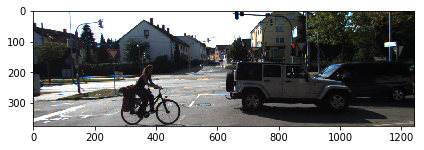

In [74]:
io.imshow(img1)

c:\users\eduard gette\appdata\local\programs\python\python36\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
c:\users\eduard gette\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


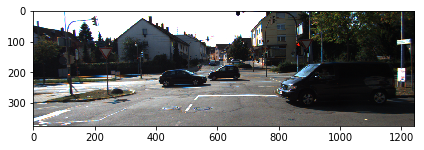

In [75]:
io.imshow(img2)

c:\users\eduard gette\appdata\local\programs\python\python36\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
c:\users\eduard gette\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


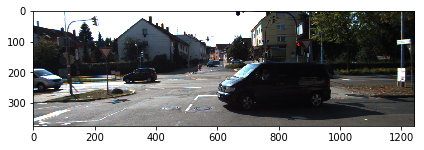

In [76]:
io.imshow(img3)

In [77]:
imgs = np.array([img1,img2,img3])
prediction = model.predict(imgs)

In [78]:
prediction[0].shape

(375, 1242, 30)

In [79]:
segmented_img1 = np.argmax(prediction[0], axis=2)
segmented_img2 = np.argmax(prediction[1], axis=2)
segmented_img3 = np.argmax(prediction[2], axis=2)

In [80]:
segmented_img

array([[ 0,  0,  0, ..., 18, 18, 18],
       [27,  0,  0, ..., 13, 13, 13],
       [ 0,  0,  0, ...,  1, 13, 13],
       ...,
       [ 9,  0,  0, ...,  0,  0, 13],
       [ 9,  0,  0, ...,  1,  1, 13],
       [28,  1, 26, ..., 26, 26, 13]], dtype=int64)

c:\users\eduard gette\appdata\local\programs\python\python36\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
c:\users\eduard gette\appdata\local\programs\python\python36\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "
c:\users\eduard gette\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


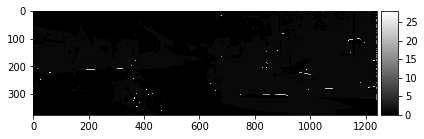

In [81]:
io.imshow(segmented_img1, cmap="gray")

c:\users\eduard gette\appdata\local\programs\python\python36\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
c:\users\eduard gette\appdata\local\programs\python\python36\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "
c:\users\eduard gette\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


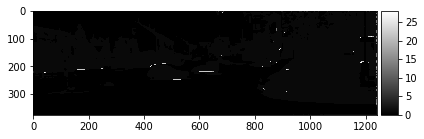

In [82]:
io.imshow(segmented_img2, cmap="gray")

c:\users\eduard gette\appdata\local\programs\python\python36\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
c:\users\eduard gette\appdata\local\programs\python\python36\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "
c:\users\eduard gette\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


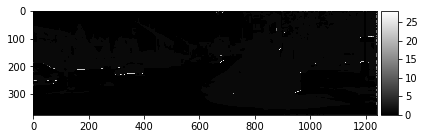

In [83]:
io.imshow(segmented_img3, cmap="gray")

- Looks reasonably well, the most visible mistakes are that it classifies shadows as part of the car and that it seems like it placed the front of the house in the center as part of the sky/background
- Also we have a little bit of odd noise = white pixels

## Exc. 7.2 FCN mit Bottleneck

Implementiere jetzt die Variante mit schrittweisem Down- und Upsampling, wie in der Vorlesung besprochen. Nutze dafür ein bestehendes Netzwerk (z.B. VGG16, https://keras.io/applications/#vgg16), entferne die FC-Schichten am Ende, und füge dann die Upsampling-Schichten hinzu. Wie in der vorigen Vorlesung zu Transfer Learning beschrieben, kannst Du jetzt nur den zweiten Teil trainieren und die Gewichte des ersten Teils "einfrieren".

Stelle wie oben den Verlauf des Losses dar und wähle einige Beispielbilder aus dem Testset und zeige sie mit ihrer vorhergesagten Segmentierung an. 

In [2]:
#https://github.com/0bserver07/Keras-SegNet-Basic/blob/master/model-basic.py

In [80]:
import keras.models as models
from keras.layers.core import Layer, Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers import Merge
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, Cropping2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint

from keras.applications.vgg16 import VGG16

In [211]:
# load the model
base_model = VGG16(include_top=False, weights='imagenet')

In [76]:
# Even with batch_size = 1 the net is too huge for memory so we have to downsample the images
X_train_ds = X_train[:,::2,::2,:]
y_train_ds = y_train[:,::2,::2]

X_test_ds = X_test[:,::2,::2,:]
y_test_ds = y_test[:,::2,::2]

print(X_train_ds.shape, X_test_ds.shape, y_train_ds.shape, y_test_ds.shape)

(80, 188, 621, 3) (20, 188, 621, 3) (80, 188, 621, 30) (20, 188, 621, 30)


In [77]:
image_input_size= (188, 621, 3)
print(image_input_size)

(188, 621, 3)


In [210]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [78]:
bottleneck_features_07 = base_model.predict(X_train_ds, batch_size=batch_size//2, verbose=1)

80/80 [==============================] - 2s 21ms/step


In [79]:
# what we have
bottleneck_features_07.shape[:]

(80, 5, 19, 512)

In [165]:
def create_upsampling_layers():
    pad_h = 1
    pad_w = 1
    pool_size = 2
    return[
        ZeroPadding2D(padding=((pad_h, 0),(0, pad_w))),
        
        UpSampling2D(size=(pool_size,pool_size)),
        #BatchNormalization(),

        UpSampling2D(size=(pool_size,pool_size)),
        #BatchNormalization(),
        
        UpSampling2D(size=(pool_size,pool_size)),
        # BatchNormalization(),

        UpSampling2D(size=(pool_size,pool_size)),
        # BatchNormalization(),
        
        UpSampling2D(size=(pool_size,pool_size)),
        # BatchNormalization()
    ]

In [212]:
my_model = Sequential()
for layer in base_model.layers:
    my_model.add(layer)

for layer in create_upsampling_layers():
    my_model.add(layer)

In [213]:
my_model.add(Convolution2D(30, (1, 1), padding ='valid',))

my_model.add(Cropping2D(cropping=((2, 2), (9, 10))))
my_model.add(Activation('sigmoid'))

In [214]:
# freeze all layers from base model
for layer in my_model.layers[:-6]:
    layer.trainable = False
    
for layer in my_model.layers[-6:]:
    layer.trainable=True

In [215]:
my_model.compile(loss="mean_squared_error", optimizer='adam', metrics=["accuracy"])

c:\users\eduard gette\appdata\local\programs\python\python36\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
c:\users\eduard gette\appdata\local\programs\python\python36\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "
c:\users\eduard gette\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


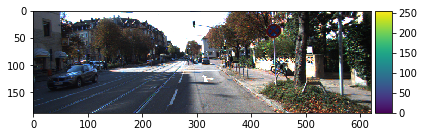

In [163]:
# check whether pictures still look reasonable after downsampling them
io.imshow(X_train_ds[1].astype(int))

In [216]:
# checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Fit the model
history = my_model.fit(X_train_ds, y_train_ds, callbacks=callbacks_list, batch_size=2, epochs=nrOfEpochs,
                       verbose=1, validation_data=(X_test_ds, y_test_ds), shuffle=False)

Train on 80 samples, validate on 20 samples
Epoch 1/20
80/80 [==============================] - 14s 171ms/step - loss: 0.2091 - acc: 0.1070 - val_loss: 0.1035 - val_acc: 0.0519

Epoch 00001: val_acc improved from -inf to 0.05193, saving model to weights.best.hdf5
Epoch 2/20
80/80 [==============================] - 13s 159ms/step - loss: 0.0846 - acc: 0.0385 - val_loss: 0.0795 - val_acc: 0.0507

Epoch 00002: val_acc did not improve
Epoch 3/20
80/80 [==============================] - 13s 161ms/step - loss: 0.0762 - acc: 0.0382 - val_loss: 0.0753 - val_acc: 0.0541

Epoch 00003: val_acc improved from 0.05193 to 0.05413, saving model to weights.best.hdf5
Epoch 4/20
80/80 [==============================] - 12s 152ms/step - loss: 0.0735 - acc: 0.0384 - val_loss: 0.0729 - val_acc: 0.0530

Epoch 00004: val_acc did not improve
Epoch 5/20
80/80 [==============================] - 10s 125ms/step - loss: 0.0716 - acc: 0.0387 - val_loss: 0.0711 - val_acc: 0.0521

Epoch 00005: val_acc did not improve


In [217]:
my_model.evaluate(x=X_test_ds, y=y_test_ds, batch_size=batch_size, verbose=1)

20/20 [==============================] - 1s 66ms/step


[0.053103599697351456, 0.05286043509840965]

In [218]:
my_model.evaluate(x=X_train_ds, y=y_train_ds, batch_size=batch_size, verbose=1)

80/80 [==============================] - 10s 120ms/step


[0.05296100489795208, 0.04302204353734851]

- This just doesn't work
- Let's see how the pictures from the last check look like anyway

In [197]:
img1 = X_test_ds[0].astype(int)
img2 = X_test_ds[10].astype(int)
img3 = X_test_ds[19].astype(int)

c:\users\eduard gette\appdata\local\programs\python\python36\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
c:\users\eduard gette\appdata\local\programs\python\python36\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "
c:\users\eduard gette\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


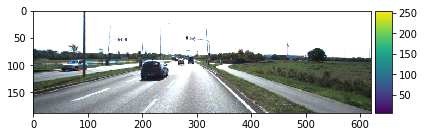

In [198]:
io.imshow(img1)

In [219]:
imgs = np.array([img1,img2,img3])
prediction = my_model.predict(imgs)

In [200]:
prediction[0].shape

(188, 621, 30)

In [220]:
segmented_img1 = np.argmax(prediction[0], axis=2)
segmented_img2 = np.argmax(prediction[1], axis=2)
segmented_img3 = np.argmax(prediction[2], axis=2)

In [202]:
segmented_img1

array([[24, 24, 24, ..., 24, 24, 24],
       [24, 24, 24, ..., 24, 24, 24],
       [24, 24, 24, ..., 24, 24, 24],
       ...,
       [ 3,  3,  3, ..., 24, 24, 24],
       [ 3,  3,  3, ..., 24, 24, 24],
       [ 3,  3,  3, ..., 24, 24, 24]], dtype=int64)

c:\users\eduard gette\appdata\local\programs\python\python36\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
c:\users\eduard gette\appdata\local\programs\python\python36\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "
c:\users\eduard gette\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


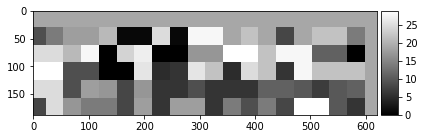

In [222]:
io.imshow(segmented_img1, cmap="gray")

c:\users\eduard gette\appdata\local\programs\python\python36\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
c:\users\eduard gette\appdata\local\programs\python\python36\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "
c:\users\eduard gette\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


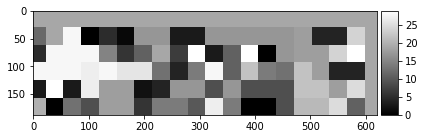

In [223]:
io.imshow(segmented_img2, cmap="gray")

c:\users\eduard gette\appdata\local\programs\python\python36\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
c:\users\eduard gette\appdata\local\programs\python\python36\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "
c:\users\eduard gette\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


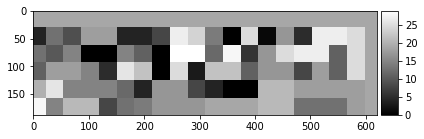

In [224]:
io.imshow(segmented_img3, cmap="gray")

Yep, total nonsense.